The objective of this tutorial is to use the Neural Equivariant Interatomic Potentials (NequIP), an E(3)-equivariant neural network approach for learning interatomic potentials from ab-initio calculations for molecular dynamics simulations.Here, the open-source code named LAMMPS (acronym for Large-scale Atomic/Molecular Massively Parallel Simulator) to perform a molecular dynamics simulation to generate training data. 

## Import modules

External modules that are imported and that need to be installed in the local environment using pip.

In [5]:
import re
import os

import torch

import numpy as np
import pandas as pd
from pandas import DataFrame

from lammps import lammps
import lammps_logfile

from nequip.ase import nequip_calculator
from nequip.utils import Config

from ase.io.lammpsdata import write_lammps_data
from ase.io.aims import write_aims
from ase.io import read, write
from ase.parallel import paropen
from ase.build import make_supercell
from ase.visualize.plot import plot_atoms
from ase import Atoms

from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import shutil
import random
import subprocess
import time
from tqdm import tqdm
import warnings

#torch.set_default_dtype(torch.float64)
warnings.filterwarnings('ignore')

## run LAMMPS

Building the initial diamond cubic crystal structure of silicon as the input configuration for LAMMPS. Here, the structure is a repeating pattern of 8 atoms and in the Fd3m space group (space group 227), which follows the face-centered cubic Bravais lattice. A 2x2x2 supercell of diamond structures is built as the input data file. 

In [2]:
def write_lammps_datafile(symbols, system_size, lattice_parameter):
    
    symbols=[symbols] * 8
    # Lattice parameter for silicon
    lattice_parameter = lattice_parameter
    # Cubic diamond basis 
    basis = np.array([[1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]])*lattice_parameter

    base_atoms = np.array([(0.00, 0.00, 0.00), 
                           (0.25, 0.25, 0.25), 
                           (0.50, 0.50, 0.00), 
                           (0.75, 0.75, 0.25),
                           (0.50, 0.00, 0.50), 
                           (0.75, 0.25, 0.75), 
                           (0.00, 0.50, 0.50),
                           (0.25, 0.75, 0.75)])*lattice_parameter

    # Size of the system cell in lattice units
    # Assuming an cubic cell starting at the origin

    system_size = system_size

    period = np.array([[1, 0, 0],
                       [0, 1, 0],
                       [0, 0, 1]])*system_size

    base_bulk = Atoms(symbols=symbols,
                      positions=base_atoms,
                      cell=basis,
                      pbc=True
                      )
    
    super_bulk = make_supercell(base_bulk, period)

    plt.axis('off')
    plot_atoms(super_bulk, rotation='190x,10y')

    fileobj="geometry_lammps_in.data"
    write_lammps_data(fileobj, super_bulk)
    
    return super_bulk

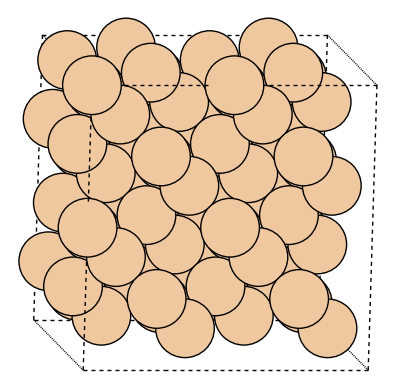

In [3]:
symbols='Si'  # symbols of the system
system_size=2  # size of supercell
lattice_parameter=5.475  # lattice constant of diamond cubic structure 
atoms=write_lammps_datafile(symbols, system_size, lattice_parameter)

LAMMPS is run by redirecting a file of input commands into it. The input file contains commands that specify the parameters for the simulation as well as read other necessary files such as a data file that describes the initial atom positions, and force-field parameters. Here, The Tersoff potential, which incorporates a dependency on the number of bonds between a pair of atoms is applied to atomic simulations. Training, validation and test data sets for liquid Si are gathered from MD trajectory (64 atom cell and 40 ps) at T = 2000 K using the experimental density (2.57 g/cm^3).

In [8]:
# run LAMMPS
devNull = open('./data/lammps.run/log.lammps_heating', 'w')
subprocess.run(["lmp_serial", "-in", "./data/lammps.run/lammps_heating_in.in"], stdout = devNull)
devNull.close()

## Visualize MD trajectories

The output file 'log.lammps' stores seven properties of simulation trajectory, including time, simulation step, temperature, potential energy, total energy, pressure and volume. The trajectory 'dump.lammpstrj' stores a number of fields describing the system through time, including the cartesian coordinates, velocity and force of each atoms, and information about the unitcell. 

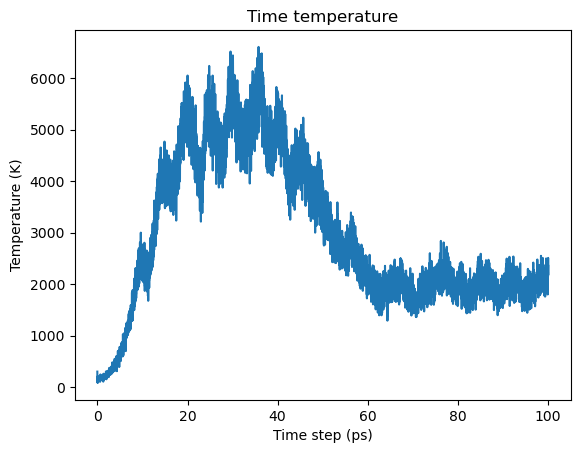

In [6]:
log = lammps_logfile.File("./data/lammps.run/log.lammps_heating")

time = log.get("Time")
temp = log.get("Temp")
energy = log.get('TotEng')

plt.plot(time, temp)
plt.xlabel('Time step (ps)')
plt.ylabel('Temperature (K)')
plt.title('Time temperature')
plt.show()

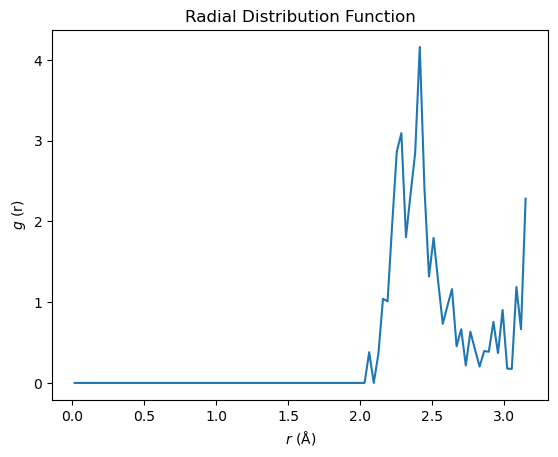

In [7]:
rdf_data=pd.read_csv('./data/lammps.run/lammps.heating.rdf', sep=' ', skiprows=range(2))
distance=rdf_data['Row'][-100: -1]
distribution=rdf_data['c_myRDF[1]'][-100: -1]
plt.plot(distance, distribution)
plt.title('Radial Distribution Function')
plt.xlabel(r'$\mathit{r}$ ' + u'(\u212B)')
plt.ylabel(r'$\mathit{g}$ ' + '(r)')
plt.show()

In this tutorial , we introduce the equivariant graph neural network to describe interatomic potentials. Here, we use Neural Equivariant Interatomic Potentials (NequIP), which is an open-source code for building E(3)-equivariant interatomic potentials, for fitting interatomic potentials of liquid silicon. To train a network, we run nequip-train with a YAML config file that describes data set, model hyperparameters, and training options. 

# NequIP Hyperparameter Optimization

In [8]:
# Read the trajectory 'dump.lammpstrj' 
def read_dump(FileName, NumAtoms, Nfield, SnapShots):
    """read lammps dumpfile with header (not saved)"""

    File = open(FileName, 'r')
    data = np.ndarray((NumAtoms, Nfield, SnapShots), dtype=float)
    cell_dir = []
    t = 0
    while (t < SnapShots):
        cell = np.zeros((3, 3))
        # read header
        h1 = File.readline()
        time = File.readline()
        h2 = File.readline()
        numatoms = File.readline()
        h3 = File.readline()
        xlen = File.readline().strip('\n').split()[1]
        ylen = File.readline().strip('\n').split()[1]
        zlen = File.readline().strip('\n').split()[1]
        cell[0, 0] = xlen
        cell[1, 1] = ylen
        cell[2, 2] = zlen
        cell_dir.append(cell)
        h4 = File.readline()
        for a in range(NumAtoms):
            # Read string -> strip '\n' char -> split into new list
            line = File.readline().strip('\n').split()
            data[a, :, t] = line[0:Nfield_dump]

        t += 1

    File.close()
    return data, np.array(cell_dir)


def read_dump_data(FileName_dump, NumAtoms, Nfield_dump, SnapShots_dump):
    atom_id_array = []
    atoms_type_array = []
    position_array = []
    velocity_array = []
    force_array = []
    data, cell_dir = read_dump(FileName_dump, NumAtoms, Nfield_dump, SnapShots_dump)
    
    for i in range(NumAtoms):
        atoms_id = data[i][0]
        atom_id_array.append(atoms_id)
        atoms_type = data[i][1]
        atoms_type_array.append(atoms_type)
        x = data[i][2]
        y = data[i][3]
        z = data[i][4]
        position = np.array([x, y, z]).T
        position_array.append(position)
        vx = data[i][5]
        vy = data[i][6]
        vz = data[i][7]
        velocity = np.array([vx, vy, vz]).T
        velocity_array.append(velocity)
        fx = data[i][8]
        fy = data[i][9]
        fz = data[i][10]
        force = np.array([fx, fy, fz]).T
        force_array.append(force)
        
    return np.array(atom_id_array), \
           np.array(atoms_type_array), \
           np.array(position_array), \
           np.array(velocity_array), \
           np.array(force_array), \
           cell_dir

# Build the training data set
def training_data(Ntrain, flag_liquid):
    # parse properties as list of dictionaries
    property_list = []
    E=[]
    F=[]
    R=[]
    z=[]
    CELL=[]
    PBC=[]

    energy_dir_liquid=energy_dir[flag_liquid:-1]
    atoms_type_dir_liquid=atoms_type_dir[:, flag_liquid:-1]
    cell_dir_liquid=cell_dir[flag_liquid:-1]
    position_dir_liquid=position_dir[:, flag_liquid:-1]
    velocity_dir_liquid=velocity_dir[:, flag_liquid:-1]
    force_dir_liquid=force_dir[:, flag_liquid:-1]
    
    random.seed(42)
    for i, step in zip(random.sample(range(0,np.shape(atom_id_dir)[1]-flag_liquid),Ntrain), tqdm(range(Ntrain))):
        atoms_snapshots = Atoms(symbols=np.array([float("14") if n==float("1.0") else n for n in atoms_type_dir_liquid[:, i]]),
                                cell=cell_dir_liquid[i],
                                positions=position_dir_liquid[:, i],
                                pbc=True,
                                velocities=velocity_dir_liquid[:, i]
                                )
        numberatoms=len(atoms_snapshots.numbers)
        E.append([energy_dir_liquid[i]])
        F.append(force_dir_liquid[:, i])
        R.append(atoms_snapshots.get_positions())
        z.append(atoms_snapshots.numbers)
        CELL.append(atoms_snapshots.get_cell())
        PBC.append(atoms_snapshots.get_pbc())

    E=np.array(E)
    F=np.array(F)
    R=np.array(R)
    z=np.array(z)
    CELL=np.array(CELL)
    PBC=np.array(PBC)
    
    return E, F, R, z, CELL, PBC

def NN_prediction(filename, ModelNameList, Ntest, force_test, position_test, symbols_test, cell_test, pbc_test):
    
    F_R2_list=[]
    F_MAE_list=[]
    for ModelName in ModelNameList:
        NN = nequip_calculator.NequIPCalculator
        NN = NN.from_deployed_model(filename + '/'+ ModelName)

        PredictedForces = np.empty([NumAtoms, 3, 0])
        ActualForces = np.empty([NumAtoms, 3, 0])
    
        print("NequIP predicting......")
        for i, j in zip(range(Ntest), tqdm(range(Ntest))):
            atoms = Atoms(symbols=np.array([float("14") if i==float("1.0") else i for i in symbols_test[i]]),
                          cell=cell_test[i],
                          positions=position_test[i],
                          pbc=True
                          )

            NN.calculate(atoms=atoms, properties=["forces"])

            PredictedForces=np.dstack((PredictedForces, NN.get_forces()))
            ActualForces=np.dstack((ActualForces, force_test[i]))

        ActualForces = ActualForces
        PredictedForces = PredictedForces

        F_R2 = r2_score(ActualForces.flatten(), PredictedForces.flatten())
        F_MAE = mean_absolute_error(ActualForces.flatten(), PredictedForces.flatten())
        print("Force R2:", F_R2)
        print("Force MAE:", F_MAE)
    
        F_R2_list.append(float(F_R2))
        F_MAE_list.append(float(F_MAE))
        
    return ActualForces, PredictedForces, F_R2_list, F_MAE_list

## Build Training, validation and test datasets 

To train a network, we run nequip-train with a YAML config file that describes the data set, model hyperparameters, and training options. Here, 5 training sets are bult, in which liquid data points are selected randomly from the MD trajectory. Besides, 500 independent liquid data points are selected randomly from the same MD trajectory as the test dataset.

The trajectory 'dump.lammpstrj' stores a number of fields describing the system through time, including the cartesian coordinates, velocity and force of each atoms, and information about the unitcell. 

In [9]:
# Training and Validation Dataset
Ntrain_list=[200, 500, 1000, 2000, 4000]
flag_liquid=70000  # sampling range of trajectories for NequIP dataset
FileName_dump = "./data/lammps.run/heating.dump"  # trajectory file of LAMMPS
Nfield_dump = 11  # number of properties in dump.lammpstrj
NumAtoms=64
SnapShots=100000+1  # total number of simulation steps

energy_dir = log.get('TotEng')
atom_id_dir, \
atoms_type_dir, \
position_dir, \
velocity_dir, \
force_dir, \
cell_dir = read_dump_data(FileName_dump, NumAtoms, Nfield_dump, SnapShots)

for ntrain in Ntrain_list:
    Ntrain=ntrain  # number of training dataset
    Nvalidation = 200  # number of validation dataset 
    Ntotal = Ntrain + Nvalidation
    energy_train, force_train, position_train, symbols_train, cell_train, pbc_train = training_data(Ntotal, flag_liquid)
    np.savez('./data/data.training/'+'nequip.'+str(ntrain)+'.train',E=energy_train,F=force_train,\
             R=position_train,z=symbols_train,CELL=cell_train,PBC=pbc_train)

# Test Dataset
Ntest=500  # number of test dataset
flag_liquid=90000  # sampling range of trajectories for NequIP dataset
energy_test, force_test, position_test, symbols_test, cell_test, pbc_test = training_data(Ntest, flag_liquid)
np.savez('./data/data.training/'+'nequip.'+str(Ntest)+'.test',E=energy_test,F=force_test,\
             R=position_test,z=symbols_test,CELL=cell_test, PBC=pbc_test)

100%|██████████████████████████████████████▉| 499/500 [00:00<00:00, 8024.99it/s]


## Definition of Hyperparameter Space

In [10]:
r_max_list=[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
l_max_list=[0, 1, 2, 3]
ntrain_list=[200, 500, 1000, 2000, 4000]
nfeatures_list=[8, 16, 32, 64]

with open("./data/nequip.run/nequip.initial.yaml", "r") as f:  # read the initial YAML document of NequIP
    nequip_parameters = f.read()  

## Test of Parameter: cutoff radius

In [13]:
# Suggested hyper_parameters from Simon's paper [Nat. Commun. 13, 2453 (2022)]
# Two folders will be used during the training: 'root'/process and 'root'/'run_name'
# r_max: cutoff radius in length units, here Angstrom, this is an important hyperparamter to scan
# l_max: the maximum irrep order (rotation order) for the network's features, l=1 is a good default, l=2 is more accurate but slower
# num_features: the multiplicity of the features, 32 is a good default for accurate network, if you want to be more accurate, go larger, if you want to be faster, go lower
# n_train: number of training data
# dataset_file_name: path to data set file

ParentPath=os.getcwd()
parameter_test="rmax"
if parameter_test=="rmax":
    lmax=str(2)  
    nfeatures=str(32)
    ntrain=str(1000)
    for rmax in r_max_list:
        rmax=str(rmax)
        nequip_parameters_test = """root: si_nequip_rmax_"""+rmax+"""/results
workdir: si_neqiup  
run_name: neqiup
r_max: """+rmax+"""                                      
l_max: """+lmax+"""                                       
num_features: """+nfeatures+"""                           
n_train: """+ntrain+"""
dataset_file_name: ./nequip."""+ntrain+""".train.npz
"""
    
        filename_rmax = "./data/nequip."+ parameter_test + ".lammps"
        fout="nequip."+ parameter_test + "." + str(rmax) +".yaml"
        modelname="deployed."+ parameter_test + "." + str(rmax) + ".pth"
        pathname="./si_nequip_rmax_"+rmax+"/results/neqiup/"
        
        os.chdir(filename_rmax)
        with open(fout, "w") as f:
            f.write(nequip_parameters_test) 
            f.write(nequip_parameters)
        if os.path.exists(modelname) == False:
            subprocess.run(["nequip-train", fout])
            subprocess.run(["nequip-deploy", "build", "--train-dir", pathname, modelname])
        else:
            print(str(modelname)+" : Training is done")
        os.chdir(ParentPath)

deployed.rmax.3.0.pth : Training is done
deployed.rmax.3.5.pth : Training is done
deployed.rmax.4.0.pth : Training is done
deployed.rmax.4.5.pth : Training is done
deployed.rmax.5.0.pth : Training is done
deployed.rmax.5.5.pth : Training is done
deployed.rmax.6.0.pth : Training is done


NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [01:14<00:00,  6.65it/s]


Force R2: 0.8299866037638144
Force MAE: 0.43929462847381734
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [01:32<00:00,  5.39it/s]


Force R2: 0.9951455693799377
Force MAE: 0.07489511373962585
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [01:49<00:00,  4.55it/s]


Force R2: 0.9947719352776264
Force MAE: 0.07671584848158926
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [02:13<00:00,  3.74it/s]


Force R2: 0.994448614070066
Force MAE: 0.07825023831607142
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [02:58<00:00,  2.79it/s]


Force R2: 0.9942661798355839
Force MAE: 0.0792526003548609
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [05:34<00:00,  1.49it/s]


Force R2: 0.9939052079815733
Force MAE: 0.08173758280680628
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [06:43<00:00,  1.24it/s]

Force R2: 0.9933279206303705
Force MAE: 0.08569223236909276


Text(25.09722222222222, 0.5, 'Test Average MAE of Force (eV/Å)')

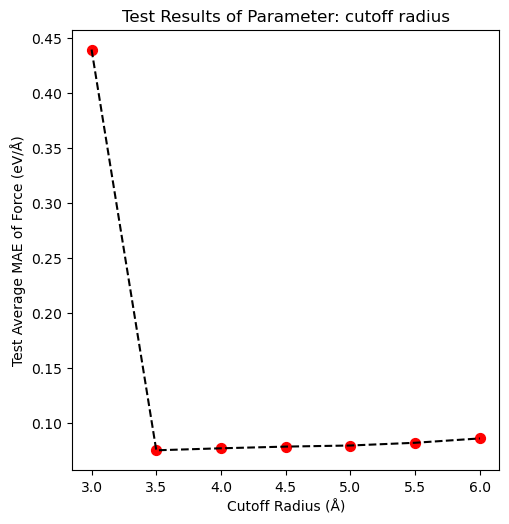

In [15]:
# Test of the trained ML potential and the illustration of the results 
ModelNameList=["deployed.rmax.3.0.pth", 
               "deployed.rmax.3.5.pth",
               "deployed.rmax.4.0.pth", 
               "deployed.rmax.4.5.pth", 
               "deployed.rmax.5.0.pth", 
               "deployed.rmax.5.5.pth", 
               "deployed.rmax.6.0.pth"
              ]

ActualForces, PredictedForces, F_R2_ramx, F_MAE_ramx=NN_prediction(filename_rmax, ModelNameList, Ntest, force_test, position_test, symbols_test, cell_test, pbc_test)
fig, ax = plt.subplots(figsize=(5, 5))
fig.tight_layout()
ax.scatter(r_max_list, F_MAE_ramx, c='r', s=50)
ax.plot(r_max_list, F_MAE_ramx, ls="--", c="k")
ax.set_title('Test Results of Parameter: cutoff radius')
ax.set_xlabel('Cutoff Radius (\u212B)')
ax.set_ylabel('Test Average MAE of Force (eV/\u212B)')

In [16]:
# The optimal hyper_parameters after the parameter test
best_rmax_index = F_MAE_ramx.index(min(F_MAE_ramx))
rmax_best = r_max_list[best_rmax_index]
print("The optimal parameter rmax : ", str(rmax_best))

The optimal parameter rmax :  3.5


## Test of Parameter: number of features

In [14]:
parameter_test="nfeatures"
if parameter_test=="nfeatures":
    rmax=str(5.0)
    lmax=str(2)
    ntrain=str(1000)
    for nfeatures in nfeatures_list:      
        nfeatures=str(nfeatures)
        nequip_parameters_test = """root: si_nequip_nfeatures_"""+nfeatures+"""/results
workdir: si_neqiup
run_name: neqiup
r_max: """+rmax+"""                                      
l_max: """+lmax+"""                                       
num_features: """+nfeatures+"""                           
n_train: """+ntrain+"""
dataset_file_name: ./nequip."""+ntrain+""".train.npz
"""  
        fout="nequip."+ parameter_test + "." + str(nfeatures) +".yaml"
        filename_nfeature = "./data/nequip."+ parameter_test + ".lammps"
        modelname="deployed."+ parameter_test + "." + str(nfeatures) +".pth"
        pathname="./si_nequip_nfeatures_"+nfeatures+"/results/neqiup/"
        
        os.chdir(filename_nfeature)
        with open(fout, "w") as f:
            f.write(nequip_parameters_test) 
            f.write(nequip_parameters)
        if os.path.exists(modelname) == False:
            subprocess.run(["nequip-train", fout])
            subprocess.run(["nequip-deploy", "build", "--train-dir", pathname, modelname])
        else:
            print(str(modelname)+" : Training is done")
            
        os.chdir(ParentPath)

deployed.nfeatures.8.pth : Training is done
deployed.nfeatures.16.pth : Training is done
deployed.nfeatures.32.pth : Training is done
deployed.nfeatures.64.pth : Training is done


NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [01:23<00:00,  5.95it/s]


Force R2: 0.9874602518894554
Force MAE: 0.11986203064500493
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [01:58<00:00,  4.22it/s]


Force R2: 0.995403312552991
Force MAE: 0.07205905245971395
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [02:43<00:00,  3.06it/s]


Force R2: 0.994587766009822
Force MAE: 0.0776805205046032
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [05:04<00:00,  1.64it/s]

Force R2: 0.993262019430825
Force MAE: 0.08579433921171614


Text(25.09722222222222, 0.5, 'Test Average MAE of Force (eV/Å)')

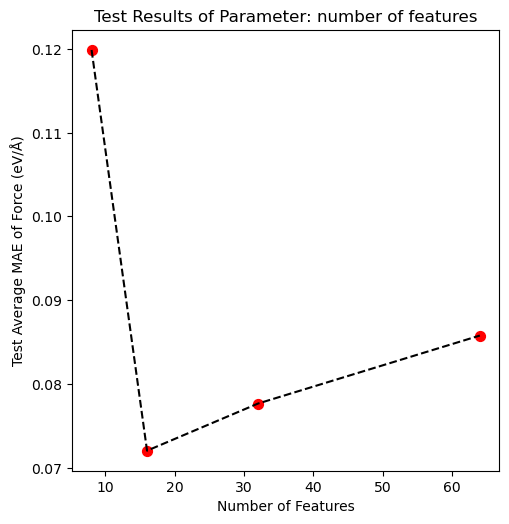

In [14]:
ModelNameList=["deployed.nfeatures.8.pth", 
               "deployed.nfeatures.16.pth", 
               "deployed.nfeatures.32.pth", 
               "deployed.nfeatures.64.pth"]

ActualForces, PredictedForces, F_R2_nfeature, F_MAE_nfeature=NN_prediction(filename_nfeature, ModelNameList, Ntest, force_test, position_test, symbols_test, cell_test, pbc_test)
fig, ax = plt.subplots(figsize=(5, 5))
fig.tight_layout()
ax.scatter(nfeatures_list, F_MAE_nfeature, c='r', s=50)
ax.plot(nfeatures_list, F_MAE_nfeature, ls="--", c="k")
ax.set_title('Test Results of Parameter: number of features')
ax.set_xlabel('Number of Features')
ax.set_ylabel('Test Average MAE of Force (eV/\u212B)')

In [15]:
best_nfeatures_index = F_MAE_nfeature.index(min(F_MAE_nfeature))
nfeatures_best = nfeatures_list[best_nfeatures_index]
print("The optimal parameter nfeatures : ", str(nfeatures_best))

The optimal parameter nfeatures :  16


## Test of Parameter: lmax and number of training data

In [15]:
parameter_test="lmax"
if parameter_test=="lmax":
    rmax=str(5.0)
    nfeatures=str(32)
    for lmax in l_max_list:
        for ntrain in ntrain_list:
            lmax=str(lmax)
            ntrain=str(ntrain)
            nequip_parameters_test = """root: si_nequip_lmax_"""+lmax+"""_ntrain_"""+ntrain+"""/results
workdir: si_neqiup
run_name: neqiup
r_max: """+rmax+"""                                      
l_max: """+lmax+"""                                       
num_features: """+nfeatures+"""                           
n_train: """+ntrain+"""
dataset_file_name: ./nequip."""+ntrain+""".train.npz
"""
            filename_lmax = "./data/nequip."+ parameter_test + ".lammps"
            fout="nequip."+ parameter_test + "." + str(lmax) +".ntrain." + str(ntrain) +".yaml"
            modelname="deployed."+ parameter_test + "." + str(lmax) + "." + str(ntrain) +".pth"
            pathname="./si_nequip_lmax_"+lmax+"_ntrain_"+ntrain+"/results/neqiup/"
            
            os.chdir(filename_lmax)
            with open(fout, "w") as f:
                f.write(nequip_parameters_test) 
                f.write(nequip_parameters)
            if os.path.exists(modelname) == False:
                subprocess.run(["nequip-train", fout])
                subprocess.run(["nequip-deploy", "build", "--train-dir", pathname, modelname])
            else:
                print(str(modelname)+" : Training is done")
            
            os.chdir(ParentPath)

deployed.lmax.0.200.pth : Training is done
deployed.lmax.0.500.pth : Training is done
deployed.lmax.0.1000.pth : Training is done
deployed.lmax.0.2000.pth : Training is done
deployed.lmax.0.4000.pth : Training is done
deployed.lmax.1.200.pth : Training is done
deployed.lmax.1.500.pth : Training is done
deployed.lmax.1.1000.pth : Training is done
deployed.lmax.1.2000.pth : Training is done
deployed.lmax.1.4000.pth : Training is done
deployed.lmax.2.200.pth : Training is done
deployed.lmax.2.500.pth : Training is done
deployed.lmax.2.1000.pth : Training is done
deployed.lmax.2.2000.pth : Training is done
deployed.lmax.2.4000.pth : Training is done
deployed.lmax.3.200.pth : Training is done
deployed.lmax.3.500.pth : Training is done
deployed.lmax.3.1000.pth : Training is done
deployed.lmax.3.2000.pth : Training is done
deployed.lmax.3.4000.pth : Training is done


NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:02<00:00,  7.95it/s]


Force R2: 0.8978748566081218
Force MAE: 0.3608947757047877
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:02<00:00,  7.95it/s]


Force R2: 0.9111701015953111
Force MAE: 0.33582994265443666
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:02<00:00,  7.93it/s]


Force R2: 0.9152508663820239
Force MAE: 0.32707046177185645
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:03<00:00,  7.88it/s]


Force R2: 0.9188550796775691
Force MAE: 0.3202678297560468
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:03<00:00,  7.87it/s]


Force R2: 0.9214357519303519
Force MAE: 0.314605263264221
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:25<00:00,  5.83it/s]


Force R2: 0.931040340129836
Force MAE: 0.2924046218168908
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:24<00:00,  5.88it/s]


Force R2: 0.951470023397842
Force MAE: 0.24081673417692115
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:25<00:00,  5.86it/s]


Force R2: 0.9657013239754083
Force MAE: 0.20342820333780517
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:28<00:00,  5.64it/s]


Force R2: 0.9732253155532522
Force MAE: 0.18083498374185586
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:25<00:00,  5.81it/s]


Force R2: 0.9780138461921514
Force MAE: 0.1656606961201977
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:47<00:00,  2.99it/s]


Force R2: 0.976933767972876
Force MAE: 0.1622005635131225
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:38<00:00,  3.16it/s]


Force R2: 0.9897669010540272
Force MAE: 0.10732307759979218
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:40<00:00,  3.11it/s]


Force R2: 0.9947412624959883
Force MAE: 0.0768306028797907
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:49<00:00,  2.95it/s]


Force R2: 0.9969903152132285
Force MAE: 0.05871872662235624
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:48<00:00,  2.96it/s]


Force R2: 0.9981452043198952
Force MAE: 0.047130451057638405
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [08:07<00:00,  1.02it/s]


Force R2: 0.9757866273366895
Force MAE: 0.1655567731557123
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [08:52<00:01,  1.07s/it]


Force R2: 0.9881852697494172
Force MAE: 0.11344162200097134
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [08:11<00:00,  1.01it/s]


Force R2: 0.9951376097970229
Force MAE: 0.0722835897252013
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [08:08<00:00,  1.02it/s]


Force R2: 0.9975618273133072
Force MAE: 0.05182866416655942
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [08:07<00:00,  1.02it/s]


Force R2: 0.9986919094749204
Force MAE: 0.038921337410773686


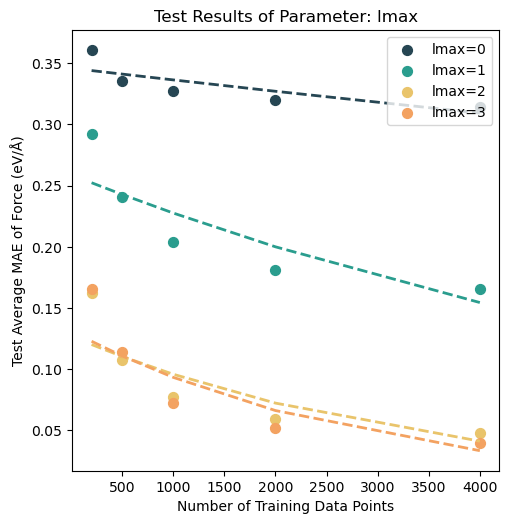

In [84]:
ModelNameList_0=["deployed.lmax.0.200.pth", 
               "deployed.lmax.0.500.pth", 
               "deployed.lmax.0.1000.pth", 
               "deployed.lmax.0.2000.pth",
                "deployed.lmax.0.4000.pth"]
ModelNameList_1=["deployed.lmax.1.200.pth", 
               "deployed.lmax.1.500.pth", 
               "deployed.lmax.1.1000.pth", 
               "deployed.lmax.1.2000.pth",
                "deployed.lmax.1.4000.pth"]
ModelNameList_2=["deployed.lmax.2.200.pth", 
               "deployed.lmax.2.500.pth", 
               "deployed.lmax.2.1000.pth", 
               "deployed.lmax.2.2000.pth",
                "deployed.lmax.2.4000.pth"]
ModelNameList_3=["deployed.lmax.3.200.pth", 
               "deployed.lmax.3.500.pth", 
               "deployed.lmax.3.1000.pth", 
               "deployed.lmax.3.2000.pth",
                "deployed.lmax.3.4000.pth"]
ModelNameListAll=[ModelNameList_0, ModelNameList_1, ModelNameList_2, ModelNameList_3]

label=["lmax=0", "lmax=1","lmax=2", "lmax=3"]
colorlist=[(38/255, 70/255, 83/255), (42/255, 157/255, 142/255),
           (233/255, 196/255, 107/255),(243/255, 162/255, 97/255)]
xlabel=np.array([200, 500, 1000, 2000, 4000])

fig, ax = plt.subplots(figsize=(5, 5))
fig.tight_layout()
for i in range(4):
    ModelNameList=ModelNameListAll[i]   
    ActualForces, PredictedForces, F_R2_lmax, F_MAE_lmax = NN_prediction(filename_lmax, ModelNameList, Ntest, force_test, position_test, symbols_test, cell_test, pbc_test)
    ax.scatter(xlabel, F_MAE_lmax, c=colorlist[i], s=50, label=label[i])
    p = np.polyfit(xlabel, np.log(np.array(F_MAE_lmax)), 1)
    ax.plot(xlabel, np.exp(p[0] * xlabel + p[1]), 'g--', c=colorlist[i], linewidth=2)
    ax.legend(loc="upper right")
    ax.set_title('Test Results of Parameter: lmax')
    ax.set_xlabel('Number of Training Data Points')
    ax.set_ylabel('Test Average MAE of Force (eV/\u212B)')

In [92]:
best_lmax_index = F_MAE_lmax.index(min(F_MAE_lmax))
lmax_best = ntrain_list[best_lmax_index]
print("The optimal parameter lamx : ", str(3))
print("The optimal parameter number_of training_data : ", lmax_best)

The optimal parameter lamx :  3
The optimal parameter number_of training_data :  4000


Steps: 
* Train: using a data set, train the neural network 
* Deploy: convert the Python-based model into a stand-alone potential file for fast execution

## NequIP test

NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [08:12<00:00,  1.01it/s]

Force R2: 0.998652183335747
Force MAE: 0.03910397290705343


Text(25.09722222222222, 0.5, 'Predicted Forces (eV/Å)')

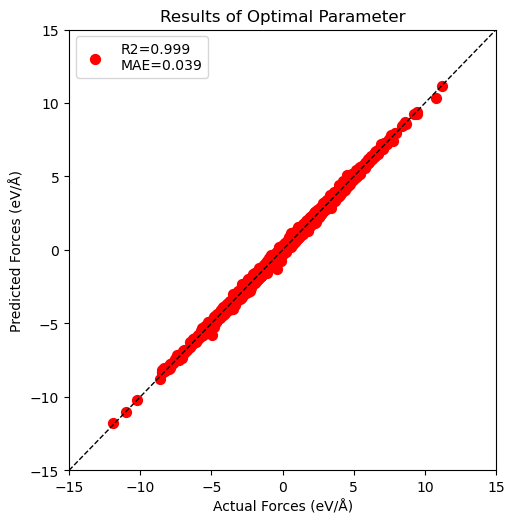

In [19]:
ModelName=['deployed.optimal.model.pth']  # saved optimal trained model
filename_optimal= './data/nequip.optimal.lammps'
ActualForces, PredictedForces, F_R2_optiaml, F_MAE_optiaml=NN_prediction(filename_optimal,ModelName, Ntest, force_test, position_test, symbols_test, cell_test, pbc_test)
fig, ax = plt.subplots(figsize=(5, 5))
fig.tight_layout()
ax.scatter(ActualForces, PredictedForces, c='r', s=50, label="R2="+str(round(F_R2_optiaml[0], 3)) +
                                                             "\nMAE=" + str(round(F_MAE_optiaml[0], 3)))
ax.plot([-15, 15], [-15, 15], ls="--", c="k", linewidth=1)
ax.legend(loc="upper left")
ax.set_ylim(-15, 15)
ax.set_xlim(-15, 15)

ax.set_title('Results of Optimal Parameter')
ax.set_xlabel('Actual Forces (eV/\u212B)')
ax.set_ylabel('Predicted Forces (eV/\u212B)')

# Prediction of structures with the trained network

We utilize the trained optimal model to predict the total energy of 6 different solid phases, including diamond, fcc, bcc, hcp, hexagonal diamond and st12. Then the predcited results are compared with the actural results calculated by LAMMPS.

Phase of silicon: diamond
Size of structure: 25


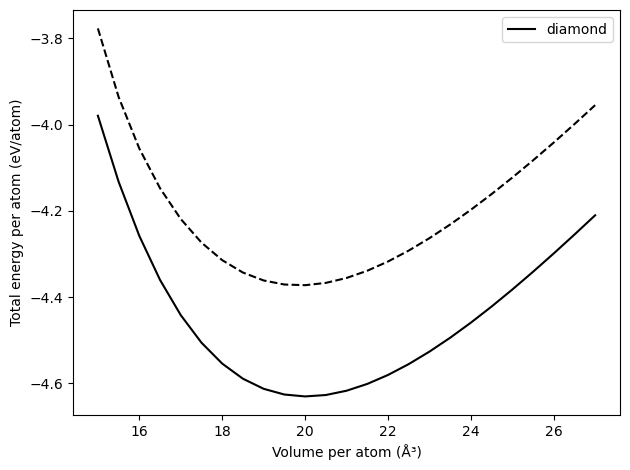

Phase of silicon: fcc
Size of structure: 23


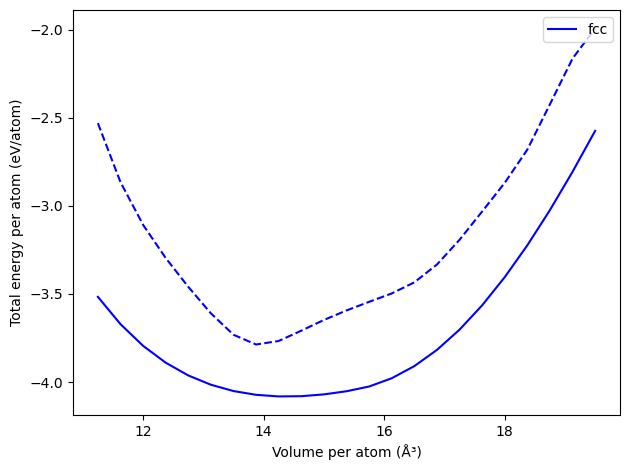

Phase of silicon: bcc
Size of structure: 20


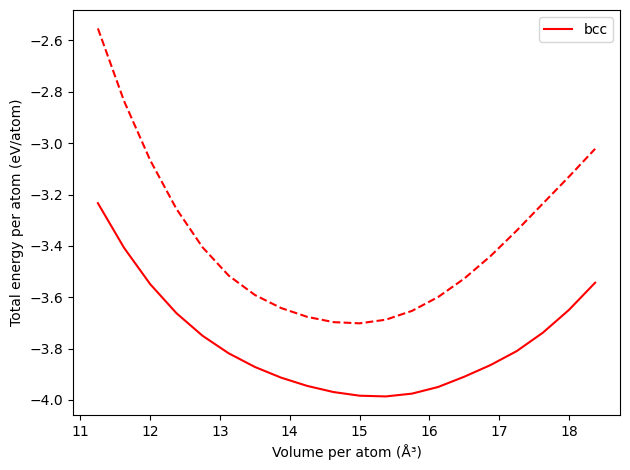

Phase of silicon: hcp
Size of structure: 20


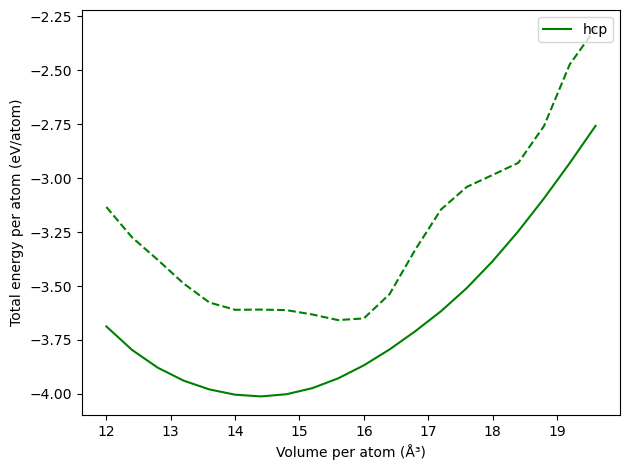

Phase of silicon: hex.dia
Size of structure: 25


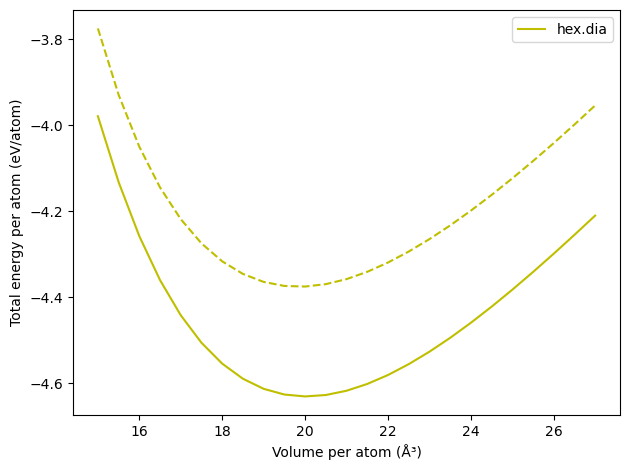

Phase of silicon: st12
Size of structure: 20


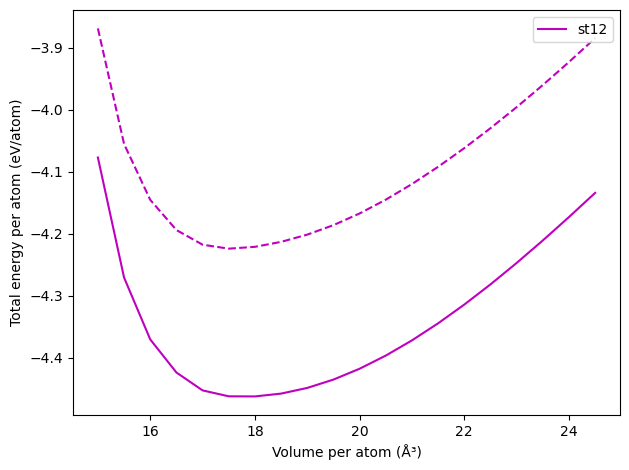

In [11]:
ModelName='deployed.optimal.model.pth'  # saved optimal trained model
ModelPaths= './data/nequip.optimal.lammps/'
DataPaths='./data/data.phase/'
Phase_silicon_database = ["diamond.db",
                          "fcc.db",
                          "bcc.db",
                          "hcp.db",
                          "hex.dia.db",
                          "st12.db"]
Phase_silicon_Natoms = [8, 4, 2, 2, 4, 12]
Phase_silicon_label = ["diamond", "fcc", "bcc", "hcp", "hex.dia", "st12"]
Phase_silicon_color = ["k", "b", "r", "g", "y", "m"]

for (phasedb, phaseNatoms, label, color) in zip(Phase_silicon_database,  
                                                Phase_silicon_Natoms, 
                                                Phase_silicon_label, 
                                                Phase_silicon_color):

    data = read(DataPaths + phasedb, index=":")
    print(f"Phase of silicon: {label}")
    print(f"Size of structure: {len(data)}")
    
    NN = nequip_calculator.NequIPCalculator
    NN = NN.from_deployed_model(ModelPaths+ModelName)
    
    Volume = np.empty([0, 1])
    PredictedEnergies = np.empty([0, 1])
    ActualEnergies = np.empty([0, 1])
    
    for datapoint in data:
        # Volume per atom
        density=datapoint.get_volume()/phaseNatoms
        Volume=np.vstack((Volume, density))
        
        # Calculate the total energy of different solid phases via LAMMPS 
        write_lammps_data('./data/lammps.run/phase.data', datapoint)
        phaselog = open('./data/lammps.run/log.phase', 'w')
        subprocess.run(["lmp_serial", "-in", "./data/lammps.run/lammps_EOS.in"], stdout = phaselog)
        phaselog.close()
        log = lammps_logfile.File('./data/lammps.run/log.phase')
        actualenergy = log.get('TotEng')[0]
        ActualEnergies=np.vstack((ActualEnergies, actualenergy/phaseNatoms))
    
        # Predict the total energy of different solid phases via NequIP 
        NN.calculate(atoms=datapoint, properties=["energy"])
        PredictedEnergies=np.vstack((PredictedEnergies, NN.get_potential_energy()/phaseNatoms))
        
    # Results visualization
    fig, ax = plt.subplots()
    ax.plot(Volume, PredictedEnergies, c=color, linestyle='dashed')
    ax.plot(Volume, ActualEnergies, c=color, linestyle='solid', label=label)
    
    ax.legend(loc="upper right")
    ax.set_xlabel('Volume per atom (' + u'\u212B\u00B3' + ')')
    ax.set_ylabel('Total energy per atom (eV/atom)')
    plt.tight_layout()
    plt.show()

## Examples with DFT Data

In this section, we utilize the data calculated by FHI-aims to train the Nequip, including hyperparameter optimization, model test and prediction of solid phases. Here, the structures of liquid silicon have 5 different densities.   

In [21]:
# Load the DFT dataset for test
data = np.load('./data/data.training/nequip.500.test.DFT.npz')

energy_test=data['E']
force_test = data['F']
position_test = data['R']
symbols_test = data['z']
cell_test = data['CELL']
pbc_test = data['PBC']
NumAtoms=64
Ntest=500

NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:43<00:00,  3.06it/s]


Force R2: 0.9923979162554964
Force MAE: 0.06861410724691665
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [04:06<00:00,  2.03it/s]


Force R2: 0.9934435815953131
Force MAE: 0.06344159499901121
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [06:34<00:00,  1.26it/s]


Force R2: 0.9938913327152616
Force MAE: 0.06122458936318298
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [10:14<00:01,  1.23s/it]


Force R2: 0.9940510641814636
Force MAE: 0.060065548503096616
NequIP predicting......


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [16:52<00:02,  2.03s/it]

Force R2: 0.9940536893919212
Force MAE: 0.05997682940691894


Text(25.09722222222222, 0.5, 'Test Average MAE of Force (eV/Å)')

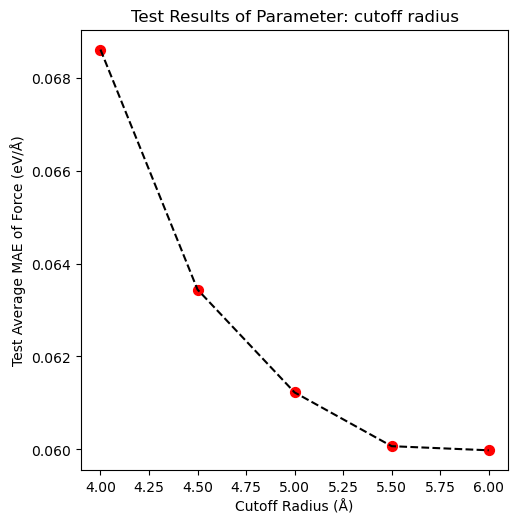

In [22]:
# Test of Parameter: cutoff radius
r_max_DFT_list=[4.0, 4.5, 5.0, 5.5, 6.0]
filename_rmax = "./data/nequip.rmax.DFT"

fig, ax = plt.subplots(figsize=(5, 5))
fig.tight_layout()
model_rmax_list = []
for rmax in r_max_DFT_list:
    modelname = 'deployed.rmax.' + str(rmax) + '.DFT.pth'
    model_rmax_list.append(modelname)
ActualForces, PredictedForces, F_R2_rmax, F_MAE_rmax = NN_prediction(filename_rmax, model_rmax_list, Ntest, force_test, position_test, symbols_test, cell_test, pbc_test)

ax.scatter(r_max_DFT_list, F_MAE_rmax, c='r', s=50)
ax.plot(r_max_DFT_list, F_MAE_rmax, ls="--", c="k")
ax.set_title('Test Results of Parameter: cutoff radius')
ax.set_xlabel('Cutoff Radius (\u212B)')
ax.set_ylabel('Test Average MAE of Force (eV/\u212B)')

NequIP predicting......


100%|████████████████████████████████████████▉| 499/500 [04:49<00:00,  1.72it/s]


Force R2: 0.9831696737014721
Force MAE: 0.10295668900893466
NequIP predicting......


100%|████████████████████████████████████████▉| 499/500 [09:45<00:01,  1.17s/it]


Force R2: 0.9725060361797101
Force MAE: 0.13197776483930104
NequIP predicting......


100%|████████████████████████████████████████▉| 499/500 [19:24<00:02,  2.33s/it]


Force R2: 0.9767001848718522
Force MAE: 0.12112005401062279
NequIP predicting......


100%|████████████████████████████████████████▉| 499/500 [36:14<00:04,  4.36s/it]


Force R2: 0.9758335402565714
Force MAE: 0.12303446820455828


Text(25.09722222222222, 0.5, 'Test Average MAE of Force (eV/Å)')

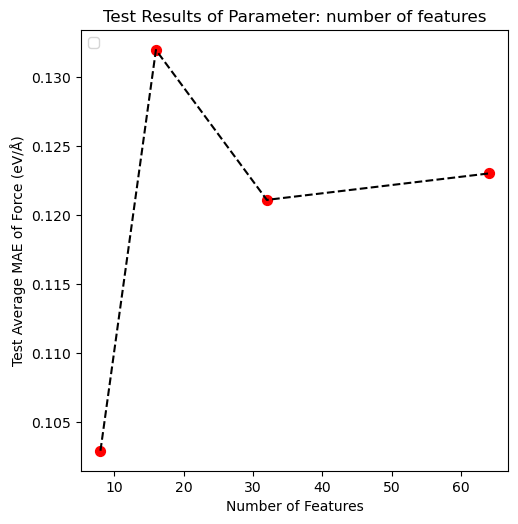

In [10]:
# Test of Parameter: number of features
nfeatures_DFT_list=[8, 16, 32, 64]
filename_nfeatures = "./data/nequip.nfeatures.DFT"

fig, ax = plt.subplots(figsize=(5, 5))
fig.tight_layout()
model_nfeatures_list = []
for nfeatures in nfeatures_DFT_list:
    modelname = 'deployed.nfeatures.' + str(nfeatures) + '.DFT.pth'
    model_nfeatures_list.append(modelname)
ActualForces, PredictedForces, F_R2_nfeatures, F_MAE_nfeatures = NN_prediction(filename_nfeatures, model_nfeatures_list, Ntest, force_test, position_test, symbols_test, cell_test, pbc_test)

ax.scatter(nfeatures_DFT_list, F_MAE_nfeatures, c='r', s=50)
ax.plot(nfeatures_DFT_list, F_MAE_nfeatures, ls="--", c="k")
ax.set_title('Test Results of Parameter: number of features')
ax.set_xlabel('Number of Features')
ax.set_ylabel('Test Average MAE of Force (eV/\u212B)')

NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:18<00:00,  6.37it/s]


Force R2: 0.9463122431050426
Force MAE: 0.1822980953772616
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:18<00:00,  6.33it/s]


Force R2: 0.947977039142384
Force MAE: 0.17943600850877806
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:18<00:00,  6.36it/s]


Force R2: 0.9485214669876586
Force MAE: 0.17854812828038155
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:19<00:00,  6.28it/s]


Force R2: 0.9491097356099567
Force MAE: 0.1775617570312975
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:22<00:00,  6.03it/s]


Force R2: 0.9494902398455684
Force MAE: 0.17683764954560896
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:22<00:00,  6.03it/s]


Force R2: 0.9498944077168159
Force MAE: 0.17607921932944232
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:48<00:00,  4.58it/s]


Force R2: 0.9640662711026923
Force MAE: 0.1502332038455359
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:48<00:00,  4.61it/s]


Force R2: 0.9681199184235942
Force MAE: 0.14151505911261839
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:48<00:00,  4.61it/s]


Force R2: 0.9709322887805429
Force MAE: 0.13541827904673828
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:48<00:00,  4.59it/s]


Force R2: 0.9724452048509172
Force MAE: 0.1318363818813619
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:48<00:00,  4.60it/s]


Force R2: 0.9726079680867857
Force MAE: 0.13133300270014572
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [01:48<00:00,  4.60it/s]


Force R2: 0.9751204824596161
Force MAE: 0.12547110843955508
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [05:01<00:00,  1.66it/s]


Force R2: 0.9868467505888687
Force MAE: 0.09138724642117632
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [05:05<00:00,  1.63it/s]


Force R2: 0.9891607443811222
Force MAE: 0.08293063413647896
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [05:05<00:00,  1.63it/s]


Force R2: 0.9902621972633399
Force MAE: 0.07866195615165665
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [05:05<00:00,  1.63it/s]


Force R2: 0.9914355655194472
Force MAE: 0.07385845893228007
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [05:04<00:00,  1.64it/s]


Force R2: 0.9914577998136725
Force MAE: 0.07367912585257506
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [05:23<00:00,  1.54it/s]


Force R2: 0.9923622268697636
Force MAE: 0.06980420218326112
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [17:54<00:02,  2.15s/it]


Force R2: 0.988854323869075
Force MAE: 0.08388372593129922
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [19:23<00:02,  2.33s/it]


Force R2: 0.9919368541847561
Force MAE: 0.0715472093289103
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [17:54<00:02,  2.15s/it]


Force R2: 0.9928962145282818
Force MAE: 0.06721701152175569
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [19:20<00:02,  2.33s/it]


Force R2: 0.9939080868886039
Force MAE: 0.06225222152975
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [19:33<00:02,  2.35s/it]


Force R2: 0.9943571240574861
Force MAE: 0.059861065236166223
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [18:03<00:02,  2.17s/it]


Force R2: 0.9944479097701284
Force MAE: 0.05937747891862715
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [59:36<00:07,  7.17s/it]


Force R2: 0.9920638241270356
Force MAE: 0.07050786518853476
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [59:41<00:07,  7.18s/it]


Force R2: 0.9944245234932242
Force MAE: 0.05897549320539726
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [55:41<00:06,  6.70s/it]


Force R2: 0.9960985149113755
Force MAE: 0.04889583509436408
NequIP predicting......


100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [1:00:02<00:07,  7.22s/it]


Force R2: 0.9966198589043522
Force MAE: 0.045953335897018215
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [55:32<00:06,  6.68s/it]


Force R2: 0.9967655732492748
Force MAE: 0.045023656095840255
NequIP predicting......


100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [59:46<00:07,  7.19s/it]


Force R2: 0.9978965696608413
Force MAE: 0.036045847443318006


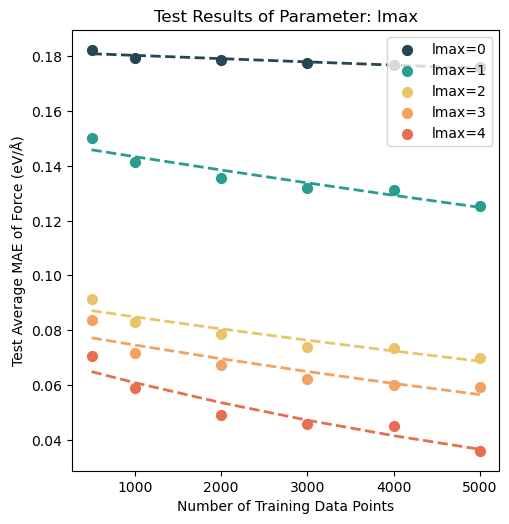

In [18]:
# Test of Parameter: lmax and number of training data
l_max_DFT_list=[0, 1, 2, 3, 4]
ntrain_DFT_list=[500, 1000, 2000, 3000, 4000, 5000]
filename_lmax = "./data/nequip.lmax.DFT"

colorlist=[(38/255, 70/255, 83/255), (42/255, 157/255, 142/255),
           (233/255, 196/255, 107/255),(243/255, 162/255, 97/255),(230/255, 111/255, 81/255)]

label=["lmax=0", "lmax=1","lmax=2", "lmax=3", "lmax=4"]
xlabel=np.array(ntrain_DFT_list)

fig, ax = plt.subplots(figsize=(5, 5))
fig.tight_layout()
for lmax in l_max_DFT_list:
    model_lmax_list = []
    for ntrain in ntrain_DFT_list:
        modelname = './model.lmax.DFT/' + 'deployed.lmax.' + str(lmax) + '.' + str(ntrain) + '.DFT.pth'
        model_lmax_list.append(modelname)
    ActualForces, PredictedForces, F_R2_lmax, F_MAE_lmax = NN_prediction(filename_lmax, model_lmax_list, Ntest, force_test, position_test, symbols_test, cell_test, pbc_test)
    
    ax.scatter(xlabel, F_MAE_lmax, c=colorlist[lmax], s=50, label=label[lmax])
    p = np.polyfit(xlabel, np.log(np.array(F_MAE_lmax)), 1)
    ax.plot(xlabel, np.exp(p[0] * xlabel + p[1]), 'g--', c=colorlist[lmax], linewidth=2)
    ax.legend(loc="upper right")
    ax.set_title('Test Results of Parameter: lmax')
    ax.set_xlabel('Number of Training Data Points')
    ax.set_ylabel('Test Average MAE of Force (eV/\u212B)')

NequIP predicting......


100%|████████████████████████████████████████▉| 499/500 [15:07<00:01,  1.82s/it]


Force R2: 0.9951132655356173
Force MAE: 0.0557730040527838


Text(25.09722222222222, 0.5, 'Predicted Forces (eV/Å)')

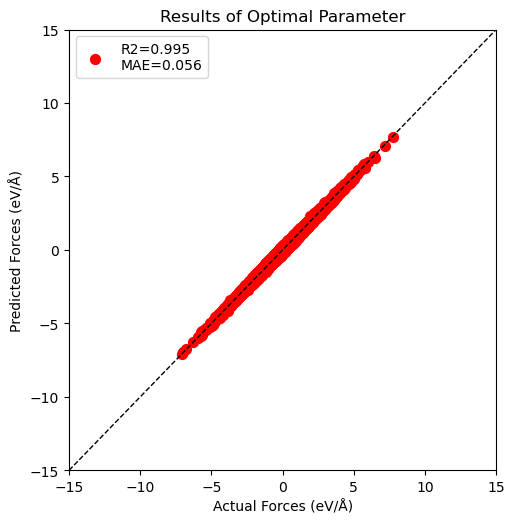

In [4]:
# Model Test
ModelName=['deployed.optimal.DFT.pth']  # saved optimal trained model
filename_optimal= './data/nequip.optimal.DFT'
ActualForces, PredictedForces, F_R2_optiaml, F_MAE_optiaml=NN_prediction(filename_optimal,ModelName, Ntest, force_test, position_test, symbols_test, cell_test, pbc_test)

fig, ax = plt.subplots(figsize=(5, 5))
fig.tight_layout()
ax.scatter(ActualForces, PredictedForces, c='r', s=50, label="R2="+str(round(F_R2_optiaml[0], 3)) +
                                                             "\nMAE=" + str(round(F_MAE_optiaml[0], 3)))
ax.plot([-15, 15], [-15, 15], ls="--", c="k", linewidth=1)
ax.legend(loc="upper left")
ax.set_ylim(-15, 15)
ax.set_xlim(-15, 15)
ax.set_title('Results of Optimal Parameter')
ax.set_xlabel('Actual Forces (eV/\u212B)')
ax.set_ylabel('Predicted Forces (eV/\u212B)')

Phase of silicon: diamond
Size of structure: 25


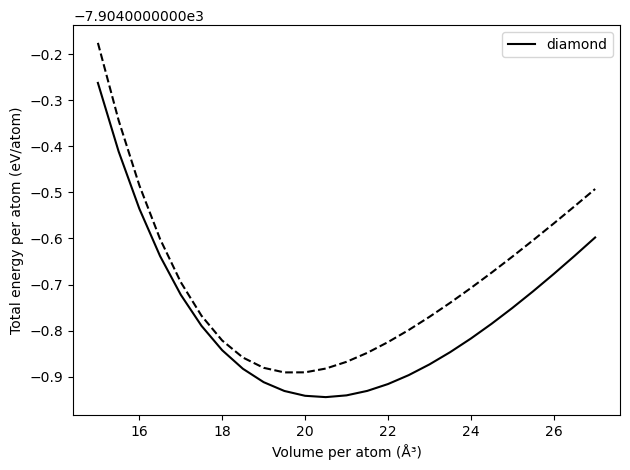

Phase of silicon: fcc
Size of structure: 23


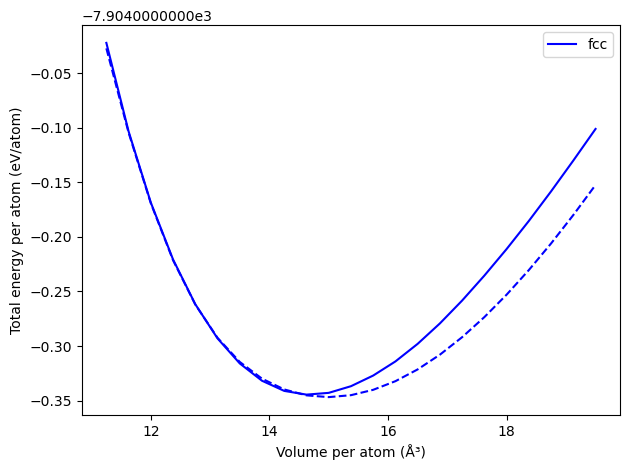

Phase of silicon: bcc
Size of structure: 20


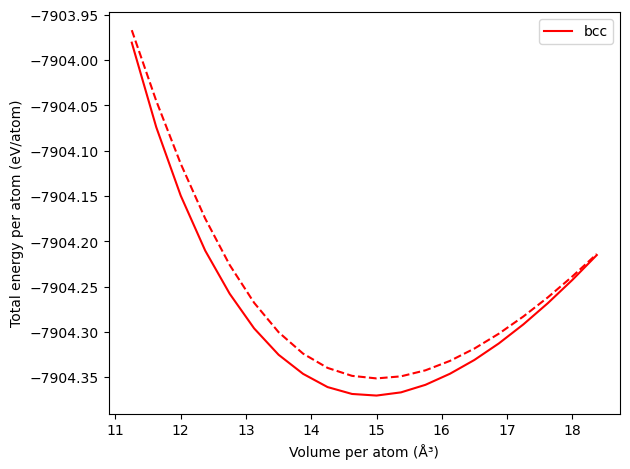

Phase of silicon: hcp
Size of structure: 20


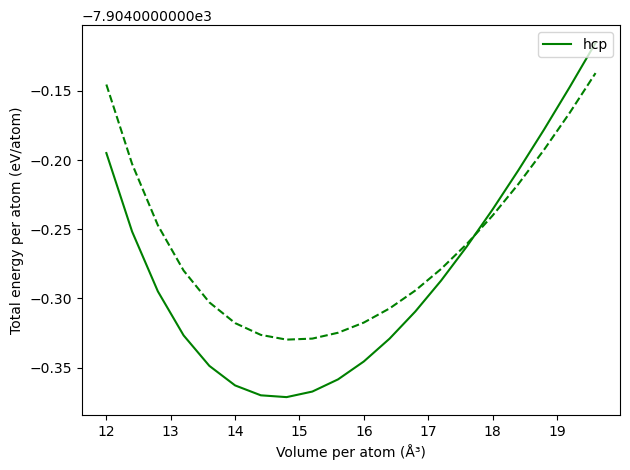

Phase of silicon: hex.dia
Size of structure: 25


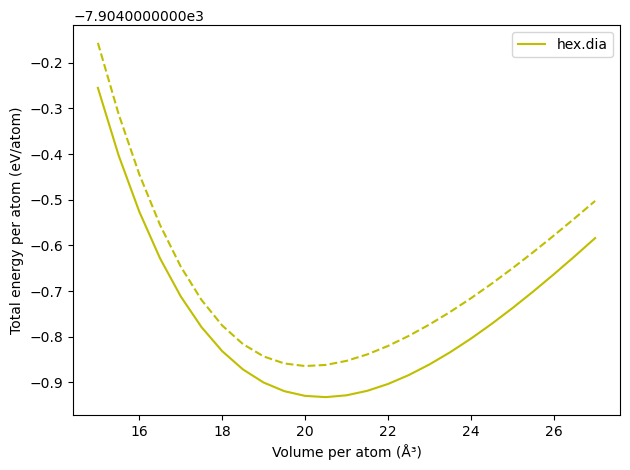

Phase of silicon: st12
Size of structure: 20


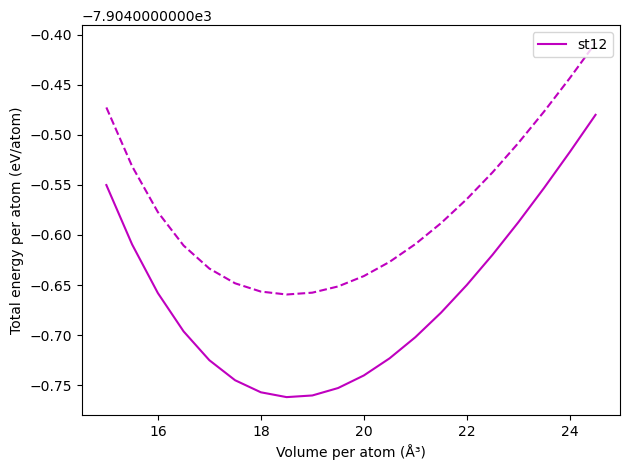

In [28]:
# Prediction of structures with the trained network
ModelName='deployed.optimal.DFT.pth'  # saved optimal trained model
ModelPaths= './data/nequip.optimal.DFT/'

Phase_silicon_EV = ["energy_volum_diamond.dat",
                    "energy_volum_fcc.dat",
                    "energy_volum_bcc.dat",
                    "energy_volum_hcp.dat",
                    "energy_volum_hex.dia.dat",
                    "energy_volum_st12.dat"]

for (phasedb, phaseEV, phaseNatoms, label, color) in zip(Phase_silicon_database, 
                                                         Phase_silicon_EV,
                                                         Phase_silicon_Natoms, 
                                                         Phase_silicon_label, 
                                                         Phase_silicon_color):

    data = read(DataPaths + phasedb, index=":")
    print(f"Phase of silicon: {label}")
    print(f"Size of structure: {len(data)}")
    
    data_DFT = pd.read_csv(DataPaths + phaseEV, sep='\s+', header=None)
    energy_DFT = data_DFT[1]
    
    NN = nequip_calculator.NequIPCalculator
    NN = NN.from_deployed_model(ModelPaths+ModelName)
    
    Volume = np.empty([0, 1])
    PredictedEnergies = np.empty([0, 1])
    ActualEnergies = np.empty([0, 1])
    for (datapoint, actualenergy) in zip(data, energy_DFT):
        # Volume per atom
        density=datapoint.get_volume()/phaseNatoms
        Volume=np.vstack((Volume, density))
        
        # Calculate the total energy of different solid phases via DFT 
        ActualEnergies=np.vstack((ActualEnergies, actualenergy))
    
        # Predict the total energy of different solid phases via NequIP 
        NN.calculate(atoms=datapoint, properties=["energy"])
        PredictedEnergies=np.vstack((PredictedEnergies, NN.get_potential_energy()/phaseNatoms))
        
    # Results visualization
    fig, ax = plt.subplots()
    ax.plot(Volume, PredictedEnergies, c=color, linestyle='dashed')
    ax.plot(Volume, ActualEnergies, c=color, linestyle='solid', label=label)
    
    ax.legend(loc="upper right")
    ax.set_xlabel('Volume per atom (' + u'\u212B\u00B3' + ')')
    ax.set_ylabel('Total energy per atom (eV/atom)')
    plt.tight_layout()
    plt.show()